In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras

from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense,GRU, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

%matplotlib inline

In [7]:
X_train = pd.read_csv('./X_train.csv')
y_train = pd.read_csv('./y_train.csv')
X_test = pd.read_csv('./X_test.csv')

X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [8]:
X_train['ang_velocity'] = np.sqrt(X_train.angular_velocity_X**2 + 
                               X_train.angular_velocity_Y**2 + 
                               X_train.angular_velocity_Z**2)

In [9]:
X_train['lin_accel'] = np.sqrt(X_train.linear_acceleration_X**2 + 
                            X_train.linear_acceleration_Y**2 + 
                            X_train.linear_acceleration_Z**2)

In [10]:
# The orientation can be represented in di 
# https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles#Source_Code_2
t3 = 2. * (X_train.orientation_W * X_train.orientation_Z + X_train.orientation_X * X_train.orientation_Y)
t4 = 1. - 2. * (X_train.orientation_Y**2 + X_train.orientation_Z**2) 
X_train['yaw'] = np.arctan2(t3, t4)

In [11]:
sinr_cosp = 2. * (X_train.orientation_W * X_train.orientation_X + X_train.orientation_Y * X_train.orientation_Z)
cosr_cosp = 1. - 2. * (X_train.orientation_X**2 + X_train.orientation_X**2)
X_train['roll'] = np.arctan2(sinr_cosp, cosr_cosp)

In [29]:
sinp = 2. * (X_train.orientation_W * X_train.orientation_Y + X_train.orientation_Z * X_train.orientation_X)

# Some rounding errors might result in sinp values like 1.00001 which would result in NaN
# force all those down to 1 (same for -1)
sinp[sinp>1] = 1
sinp[sinp<-1] = -1

X_train['pitch'] = np.arcsin(sinp)

In [30]:

X_arr = X_train[X_train.columns[1:]].values

In [31]:
X = X_arr.reshape((n_series, 128 , X_arr.shape[1]))

In [34]:
# Get rid of the series_id and measurment number, we don't want the models to see them
X = X[:,:,2:]

In [37]:
# The numpy way
means = np.mean(X, axis=1)
means.shape
# note the shape, we averaged the 128 measurements in each series, 
# so the axis for measurement number is gone, but the features are still here.

(3810, 15)

In [40]:
target = y_train['surface']
n_labels = target.nunique()
labels_names = target.unique()
le = LabelEncoder()
target = le.fit_transform(target.values)
target = to_categorical(target)
target


array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [41]:
X_train, X_val, Y_train, Y_val = train_test_split(X, target, test_size=0.2, random_state=0)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train)

Train shape (3048, 128, 15)
Validation shape (762, 128, 15)


array([[[-0.46882   ,  0.86955   ,  0.13206   , ..., -2.14980716,
          1.19492105, -0.26897739],
        [-0.46887   ,  0.86952   ,  0.13204   , ..., -2.14968157,
          1.19540533, -0.26895393],
        [-0.4689    ,  0.86951   ,  0.13201   , ..., -2.1496183 ,
          1.195669  , -0.26893307],
        ..., 
        [-0.47604   ,  0.86578   ,  0.13109   , ..., -2.13364268,
          1.27268453, -0.26888865],
        [-0.4761    ,  0.86575   ,  0.13112   , ..., -2.13352642,
          1.27341307, -0.26891517],
        [-0.47617   ,  0.86572   ,  0.13109   , ..., -2.13338149,
          1.27415009, -0.26886   ]],

       [[-0.95569   , -0.25386   , -0.044897  , ...,  0.52132639,
          3.03107647,  0.15863693],
        [-0.95544   , -0.2548    , -0.045062  , ...,  0.5232988 ,
          3.03102524,  0.15915765],
        [-0.95519   , -0.25575   , -0.04526   , ...,  0.52530572,
          3.03095993,  0.15974983],
        ..., 
        [-0.92158   , -0.35878   , -0.060971  , ...,

In [42]:
epochs = 100
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

In [43]:
model = Sequential()
model.add(GRU(80, input_shape=(128,15), activation='softsign', return_sequences=True))
model.add(GRU(160, activation='softsign'))
model.add(Dropout(0.25))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='softsign'))
model.add(Dense(9, activation='softmax'))
sgd = SGD(momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128, 80)           23040     
_________________________________________________________________
gru_2 (GRU)                  (None, 160)               115680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                6440      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 369       
Total params: 147,169
Trainable params: 147,169
Non-trainable params: 0
_________________________________________________________________


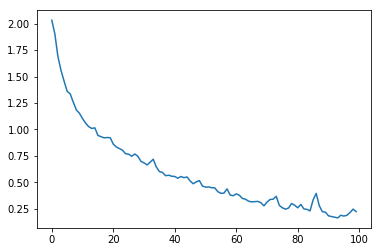

In [47]:
plt.plot(history.history['loss'])
model.summary()

In [48]:
X_test = pd.read_csv('./X_test.csv')
X_test.tail()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
488443,3815_123,3815,123,-0.96683,0.20760,0.021964,-0.14715,-0.000390,-0.21457,0.57327,1.11380,3.9277,-9.0971
488444,3815_124,3815,124,-0.96668,0.20832,0.022090,-0.14712,-0.001529,-0.18984,0.56691,0.22492,3.4683,-9.4288
488445,3815_125,3815,125,-0.96653,0.20902,0.022185,-0.14713,0.001642,-0.16331,0.56650,0.66608,3.6620,-8.9208
488446,3815_126,3815,126,-0.96637,0.20974,0.022284,-0.14710,-0.000159,-0.16968,0.57515,0.37295,3.5197,-8.4622
488447,3815_127,3815,127,-0.96621,0.21048,0.022436,-0.14709,-0.023368,-0.20818,0.57540,0.40491,3.6126,-8.5836


Seriens #5, surface: tiled


127

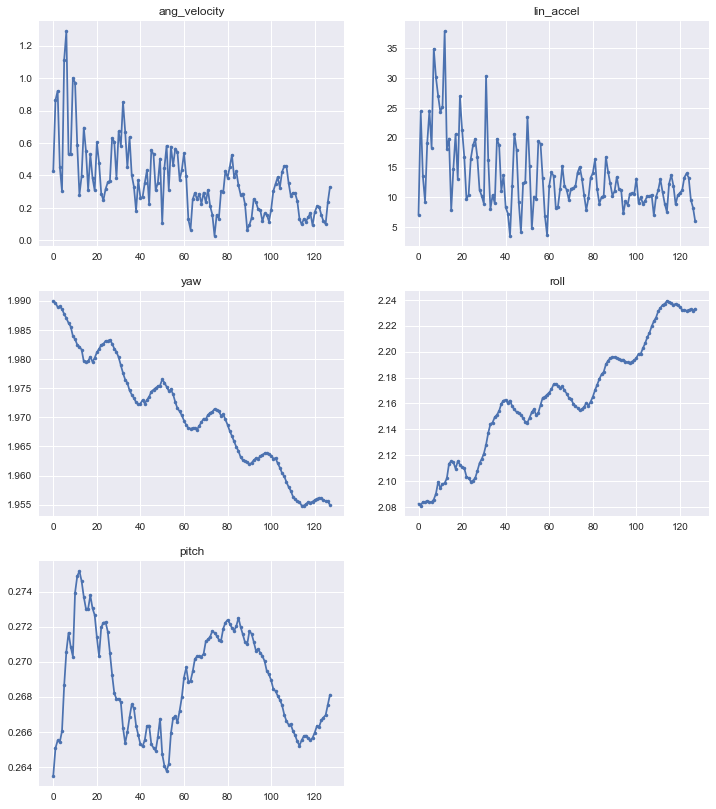

In [45]:
# Total angular velocity
X_test['ang_velocity'] = np.sqrt(X_test.angular_velocity_X**2 + 
                               X_test.angular_velocity_Y**2 + 
                               X_test.angular_velocity_Z**2)
# Total linear acceleration
X_test['lin_accel'] = np.sqrt(X_test.linear_acceleration_X**2 + 
                            X_test.linear_acceleration_Y**2 + 
                            X_test.linear_acceleration_Z**2)
# The orientation can be represented in di 
# https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles#Source_Code_2
t3 = 2. * (X_test.orientation_W * X_test.orientation_Z + X_test.orientation_X * X_test.orientation_Y)
t4 = 1. - 2. * (X_test.orientation_Y**2 + X_test.orientation_Z**2) 
X_test['yaw'] = np.arctan2(t3, t4)

sinr_cosp = 2. * (X_test.orientation_W * X_test.orientation_X + X_test.orientation_Y * X_test.orientation_Z)
cosr_cosp = 1. - 2. * (X_test.orientation_X**2 + X_test.orientation_X**2)
X_test['roll'] = np.arctan2(sinr_cosp, cosr_cosp)

sinp = 2. * (X_test.orientation_W * X_test.orientation_Y + X_test.orientation_Z * X_test.orientation_X)

# Some rounding errors might result in sinp values like 1.00001 which would result in NaN
# force all those down to 1 (same for -1)
sinp[sinp>1] = 1
sinp[sinp<-1] = -1

X_test['pitch'] = np.arcsin(sinp)


# Plot the computed features for one sample

computed_cols = ['ang_velocity',
                 'lin_accel',
                 'yaw',
                 'roll',
                 'pitch',
                 ]


series = 5
df = X_test[X_test.series_id==series]
surface = y_train[y_train.series_id==series].surface.iloc[0]
print('Seriens #%d, surface: %s' %(series, surface))

plt.figure(figsize=(12,24))

for i, col in enumerate(computed_cols):
    plt.subplot(5,2,i+1)
    plt.plot(df.measurement_number, df[col], '.-')
    plt.title(col)
    
# How long is the longest series?
X_test.measurement_number.max()

In [55]:
# how many series do we have there?
n_series = X_test.shape[0]//128
n_series

3816

In [56]:
X_arr_test = X_test[X_test.columns[1:]].values


In [57]:
test = X_arr_test.reshape((n_series, 128 , X_arr_test.shape[1]))

In [58]:
# Check that the series id looks right
test[:,:,0].astype(int)

# Check that the measurement number looks right
test[:,:,1].astype(int)

array([[  0,   1,   2, ..., 125, 126, 127],
       [  0,   1,   2, ..., 125, 126, 127],
       [  0,   1,   2, ..., 125, 126, 127],
       ..., 
       [  0,   1,   2, ..., 125, 126, 127],
       [  0,   1,   2, ..., 125, 126, 127],
       [  0,   1,   2, ..., 125, 126, 127]])

In [68]:
df.head()

,series_id,surface
0,0,tiled
1,1,carpet
2,2,tiled
3,3,wood
4,4,soft_pvc


In [69]:
submission = pd.read_csv('./sample_submission.csv')
submission['surface'] = df['surface']
submission.head()

,series_id,surface
0,0,tiled
1,1,carpet
2,2,tiled
3,3,wood
4,4,soft_pvc


In [70]:
submission.to_csv('submission', index = False)